#  目的
evalをQWKにする

In [1]:
# path setting
EXP_NAME = "e008-reg-eval-opt-qwk"
MODEL_NAME = "microsoft/deberta-v3-base"
COMPETITION_NAME = "automated_essay_scoring"

DATA_PATH = "data"
DATASET_NAME = f"{EXP_NAME}-{MODEL_NAME.split('/')[-1]}"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

# model parameter
TRAINING_MAX_LENGTH = 512
SEED = 42
EPOCH = 3
LR = 2e-05
TRAIN_BS = 4 # 8
GRAD_ACC_NUM = 16
EVAL_BS = 4 # 8
SAVE_STEP = 0.1
EVAL_STEP = 0.1

TRAINED_MODEL_PATH = "/notebooks/automated_essay_scoring/trained_models/e005-regression"

In [2]:
!nvidia-smi

Tue May 14 22:08:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:00:05.0 Off |                  Off |
| 30%   35C    P8    16W / 300W |      1MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!python --version

Python 3.11.7


In [4]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return f"../../{base_path}"
    else:
        raise Exception("Unknown environment")


DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)

/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../data
/notebooks/automated_essay_scoring/automated_essay_scoring/exp
Jupyter Lab!
../../trained_models/e008-reg-eval-opt-qwk


In [5]:
def validate_dataset_name(dataset_name: str) -> None:
    if len(dataset_name) < 6 or len(dataset_name) > 50:
        raise Exception(
            f"データセットの文字列は6~50文字にしてください。現在{len(DATASET_NAME)}文字"
        )
    if "_" in dataset_name:
        raise Exception("datasetの名称に_の使用は禁止です")


validate_dataset_name(DATASET_NAME)

# install

In [6]:
%pip install -qq polars==0.20.23
%pip install -qq transformers==4.40.1
%pip install -qq datasets==2.19.0
%pip install -qq evaluate==0.4.2
%pip install -qq seqeval==1.2.2
%pip install -qq accelerate==0.30.0
%pip install -qq python-dotenv==1.0.1
%pip install -qq wandb==0.16.6

# formatter
%pip install -qq black isort

%pip install -qq kaggle

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# import

In [7]:
import json
import os
import random

import evaluate
import numpy as np
import polars as pl
import torch
import wandb
from datasets import ClassLabel, DatasetDict, Value, concatenate_datasets, load_dataset
from tokenizers import AddedToken
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from tokenizers import AddedToken
from sklearn.metrics import cohen_kappa_score

2024-05-14 22:09:22.251428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 22:09:22.251599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 22:09:22.331541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 22:09:22.497709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 22:09:24.045057: W tensorflow/compiler/tf2

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"
NUM_PROC = os.cpu_count()

In [9]:
import transformers
import datasets
import evaluate

assert transformers.__version__ == "4.40.1"
assert datasets.__version__ == "2.19.0"
assert evaluate.__version__ == "0.4.2"

In [10]:
# Seed the same seed to all
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(SEED)

In [11]:
from dotenv import load_dotenv

load_dotenv(f"{DATA_PATH}/.env")

True

# Wandb

In [12]:
if WANDB:
    wandb.login(key=os.environ["WANDB_API_KEY"])
    wandb.init(project="automated_essay_scoring", name=EXP_NAME)
    REPORT_TO = "wandb"
else:
    REPORT_TO = "none"

REPORT_TO

'wandb'

# Data Import

In [13]:
train_dataset = load_dataset(
    "csv",
    data_files={"train": f"{DATA_PATH}/train.csv"},
    split="train",
)

train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'score'],
    num_rows: 17307
})

In [14]:
if DEBUG:
    train_dataset = train_dataset.select(range(100))
    EPOCH = 1
    SAVE_STEP = 0.5
    EVAL_STEP = 0.5

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(AddedToken("\n", normalized=False)) 

1

In [16]:
def preprocess_function(examples):
    return tokenizer(
        examples["full_text"],
        max_length=TRAINING_MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )


train_dataset = train_dataset.map(preprocess_function, batched=True, num_proc=NUM_PROC)

In [17]:
train_dataset = train_dataset.rename_column("score", "labels")

In [18]:
set(train_dataset["labels"])

{1, 2, 3, 4, 5, 6}

In [19]:
with open(f"{DATA_PATH}/essay_id_fold_dict.json") as f:
    essay_id_fold_dict = json.load(f)

In [20]:
train_dataset

Dataset({
    features: ['essay_id', 'full_text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 17307
})

In [21]:
train_dataset = train_dataset.map(
    lambda x: {"fold": essay_id_fold_dict[x["essay_id"]]}, num_proc=NUM_PROC
)

train_test_split_dataset = DatasetDict(
    {
        "train": train_dataset.filter(lambda x: x["fold"] != 2, num_proc=NUM_PROC),
        "valid": train_dataset.filter(lambda x: x["fold"] == 2, num_proc=NUM_PROC),
    }
)

# Check
assert set(train_test_split_dataset["train"]["fold"]) == {0, 1}
assert set(train_test_split_dataset["valid"]["fold"]) == {2}

if not DEBUG:
    essay_id_fold_2 = {key for key, value in essay_id_fold_dict.items() if value == 2}
    assert set(train_test_split_dataset["valid"]["essay_id"]) == essay_id_fold_2
    assert len(set(train_test_split_dataset["valid"]["essay_id"])) == 5769

In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=16)

In [23]:
import numpy as np
import scipy as sp
from functools import partial

# https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5#optimizedrounder
class OptimizedRounder:
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6

        ll = cohen_kappa_score(y, X_p, weights="quadratic")
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [1.5, 2.5, 3.5, 4.5, 5.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 1
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 2
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 3
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 4
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 5
            else:
                X_p[i] = 6
        return X_p

    @property
    def coefficients(self):
        return self.coef_['x']

# optR = OptimizedRounder()
# optR.fit(valid_pred, valid_dataset["labels"])
# print(optR.coefficients)

# optimized = optR.predict(valid_pred, optR.coefficients)

In [24]:
# https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800
def compute_metrics_for_classification(eval_pred):

    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights="quadratic")
    results = {"qwk": qwk}
    return results


from sklearn.metrics import mean_squared_error
def compute_metrics_for_regression(eval_pred):
    predictions, labels = eval_pred
    mse = mean_squared_error(labels, predictions)
    return {"mse": mse}

def compute_metrics_for_regression_opt(eval_pred):
    predictions, labels = eval_pred
    
    optR = OptimizedRounder()
    optR.fit(predictions, labels)
    print(optR.coefficients)
    optimized = optR.predict(predictions, optR.coefficients)
    
    qwk = cohen_kappa_score(labels, optimized, weights="quadratic")
    return {"qwk": qwk}

In [25]:
# regression
# https://discuss.huggingface.co/t/how-to-set-up-trainer-for-a-regression/12994
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)

# cast labels to float for regression
train_test_split_dataset = DatasetDict(
    {
        "train": train_test_split_dataset["train"].cast_column(
            "labels", Value(dtype="float")
        ),
        "valid": train_test_split_dataset["valid"].cast_column(
            "labels", Value(dtype="float")
        ),
    }
)
print(train_test_split_dataset)

In [26]:
# if not DEBUG:
#     assert len(set(train_test_split_dataset["train"]["labels"])) == NUM_LABELS
#     assert len(set(train_test_split_dataset["valid"]["labels"])) == NUM_LABELS

In [27]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_PATH,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    gradient_accumulation_steps=GRAD_ACC_NUM,
    eval_accumulation_steps=GRAD_ACC_NUM,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCH,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=EVAL_STEP,
    save_strategy="steps",
    save_steps=SAVE_STEP,
    save_total_limit=1,
    seed=SEED,
    metric_for_best_model="qwk",
    # metric_for_best_model="mse",
    warmup_ratio=0.1,
    lr_scheduler_type="cosine_with_restarts",
    report_to=REPORT_TO,
    run_name=EXP_NAME,
    load_best_model_at_end=True,
    fp16=True,
    fp16_full_eval=True,
    gradient_checkpointing=True,
    greater_is_better=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split_dataset["train"],
    eval_dataset=train_test_split_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics_for_regression,
    compute_metrics=compute_metrics_for_regression_opt
)

In [28]:
if TRAINING:
    # モデルの学習
    trainer.train()
    # ログの保存に利用したストレージを削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}/checkpoint-*")
    # モデルの保存
    trainer.save_model(MODEL_OUTPUT_PATH)
else:
    # TRAINED_MODEL_PATHを用いて、学習済のモデルを読み込む
    model = AutoModelForSequenceClassification.from_pretrained(
        TRAINED_MODEL_PATH,
        num_labels=1,
        problem_type="regression",
    )
    
    args = TrainingArguments(
        ".", 
        per_device_eval_batch_size=4,
        report_to="none",
        fp16=True,
    )

    trainer = Trainer(
        model=model, 
        args=args,
        data_collator=data_collator, 
        tokenizer=tokenizer,
    )

Step,Training Loss,Validation Loss,Qwk
54,No log,0.951244,0.406313
108,No log,0.443125,0.734076
162,No log,0.403230,0.775630
216,No log,0.401798,0.771847
270,No log,0.439570,0.761241
324,No log,0.455516,0.778353
378,No log,0.363206,0.803404
432,No log,0.357201,0.803469
486,No log,0.354551,0.805983
540,1.133900,0.354757,0.805445


# valid_datasetの作成・保存

In [29]:
valid_dataset = train_test_split_dataset["valid"]

def add_valid_pred(example, idx, valid_pred):
    example["valid_pred"] = valid_pred[idx]
    return example


valid_pred = trainer.predict(valid_dataset).predictions.flatten()

np.save(f"{MODEL_OUTPUT_PATH}/valid_prediction.npy", valid_pred)

valid_dataset = valid_dataset.map(
    add_valid_pred, with_indices=True, fn_kwargs={"valid_pred": valid_pred}
)

Map:   0%|          | 0/5769 [00:00<?, ? examples/s]

In [30]:
valid_dataset.save_to_disk(f"{MODEL_OUTPUT_PATH}/valid_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/5769 [00:00<?, ? examples/s]

# CVの計算

In [ ]:
# for regression
def clip_valid_pred(example):
    # 四捨五入を実施
    example["valid_pred"] = np.clip(example["valid_pred"], 1, 6).round()
    return example

valid_dataset = valid_dataset.map(clip_valid_pred)

cv_score = cohen_kappa_score(
    valid_dataset["labels"], valid_dataset["valid_pred"], weights="quadratic"
)

print(f"CV Score by round: {cv_score}")

In [31]:
optR = OptimizedRounder()
optR.fit(valid_pred, valid_dataset["labels"])
print(optR.coefficients)

optimized = optR.predict(valid_pred, optR.coefficients)

In [32]:
np.save(f"{MODEL_OUTPUT_PATH}/opt_thr.npy", optR.coefficients)

In [34]:
cv_score = cohen_kappa_score(
    valid_dataset["labels"], optimized, weights="quadratic"
)

print(f"CV Score by NelderMead: {cv_score}")

In [35]:
# output_textを保存
with open(f"{MODEL_OUTPUT_PATH}/cv_score.txt", "w") as f:
    f.write(str(cv_score))

# 混同行列の計算

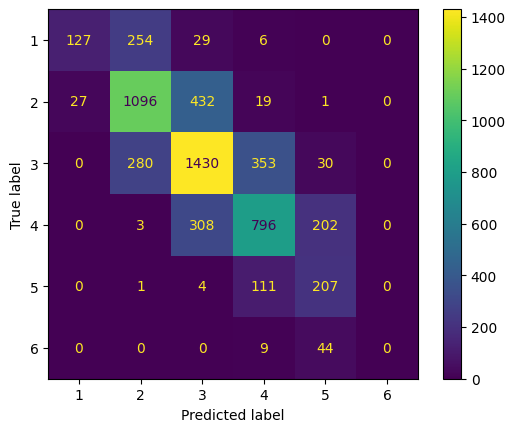

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    valid_dataset["labels"],
    valid_dataset["valid_pred"],
    labels=[x for x in range(1, 7)],
)

draw_cm = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[x for x in range(1, 7)]
)

draw_cm.plot()
plt.savefig(f"{MODEL_OUTPUT_PATH}/confusion_matrix.png")
plt.show()

# AWSへのアップロード

In [12]:
# S3へのアップロード
if not DEBUG and UPLOAD_DATA_TO_S3:
    # uninstall
    !sudo rm /usr/bin/aws
    !sudo rm /usr/bin/aws_completer
    !sudo rm -rf /usr/local/aws-cli

    # install
    !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
    !unzip -o -qq awscliv2.zip
    !sudo ./aws/install --update

    # upload
    output_name = MODEL_OUTPUT_PATH.split("/")[-1]
    os.system(
        f"aws s3 cp --recursive {MODEL_OUTPUT_PATH} s3://automated-essay-scoring/trained_model/{output_name}"
    )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57.7M  100 57.7M    0     0   225M      0 --:--:-- --:--:-- --:--:--  224M
You can now run: /usr/local/bin/aws --version
upload: ../../trained_models/e008-reg-eval-opt-qwk/cv_score.txt to s3://automated-essay-scoring/trained_model/e008-reg-eval-opt-qwk/cv_score.txt
upload: ../../trained_models/e008-reg-eval-opt-qwk/special_tokens_map.json to s3://automated-essay-scoring/trained_model/e008-reg-eval-opt-qwk/special_tokens_map.json
upload: ../../trained_models/e008-reg-eval-opt-qwk/opt_thr.npy to s3://automated-essay-scoring/trained_model/e008-reg-eval-opt-qwk/opt_thr.npy
upload: ../../trained_models/e008-reg-eval-opt-qwk/added_tokens.json to s3://automated-essay-scoring/trained_model/e008-reg-eval-opt-qwk/added_tokens.json
upload: ../../trained_models/e008-reg-eval-opt-qwk/tokenizer_config.json to s3://automated-essay-scoring/tr

In [38]:
# ダウンロード（参考）
# !sudo rm /usr/bin/aws
# !sudo rm /usr/bin/aws_completer
# !sudo rm -rf /usr/local/aws-cli

# !curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
# !unzip -o -qq awscliv2.zip
# !sudo ./aws/install --update

# !aws s3 cp --recursive s3://automated-essay-scoring/trained_model/e005-regression /notebooks/automated_essay_scoring/trained_models/e005-regression

# Kaggle Datasetへのupload

In [13]:
if not DEBUG and UPLOAD_DATA_TO_KAGGLE:
    import os
    import json

    from kaggle.api.kaggle_api_extended import KaggleApi

    def dataset_create_new(dataset_name: str, upload_dir: str):
        # if "_" in dataset_name:
        #     raise ValueError("datasetの名称に_の使用は禁止です")
        dataset_metadata = {}
        dataset_metadata["id"] = f"sinchir0/{dataset_name}"
        dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
        dataset_metadata["title"] = dataset_name
        with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
            json.dump(dataset_metadata, f, indent=4)
        api = KaggleApi()
        api.authenticate()
        api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")

    print(f"Create Dataset name:{DATASET_NAME}, output_dir:{MODEL_OUTPUT_PATH}")
    dataset_create_new(dataset_name=DATASET_NAME, upload_dir=MODEL_OUTPUT_PATH)

Create Dataset name:e008-reg-eval-opt-qwk-deberta-v3-base, output_dir:../../trained_models/e008-reg-eval-opt-qwk
Starting upload for file cv_score.txt


100%|██████████| 18.0/18.0 [00:00<00:00, 53.1B/s]


Upload successful: cv_score.txt (18B)
Starting upload for file training_args.bin


100%|██████████| 4.93k/4.93k [00:00<00:00, 15.3kB/s]


Upload successful: training_args.bin (5KB)
Starting upload for file tokenizer.json


100%|██████████| 8.26M/8.26M [00:00<00:00, 17.6MB/s]


Upload successful: tokenizer.json (8MB)
Starting upload for file valid_prediction.npy


100%|██████████| 22.7k/22.7k [00:00<00:00, 58.6kB/s]


Upload successful: valid_prediction.npy (23KB)
Starting upload for file confusion_matrix.png


100%|██████████| 28.8k/28.8k [00:00<00:00, 86.6kB/s]


Upload successful: confusion_matrix.png (29KB)
Starting upload for file opt_thr.npy


100%|██████████| 168/168 [00:00<00:00, 496B/s]


Upload successful: opt_thr.npy (168B)
Starting upload for file config.json


100%|██████████| 958/958 [00:00<00:00, 2.92kB/s]


Upload successful: config.json (958B)
Starting upload for file valid_dataset.tar


100%|██████████| 28.6M/28.6M [00:00<00:00, 46.9MB/s]


Upload successful: valid_dataset.tar (29MB)
Starting upload for file added_tokens.json


100%|██████████| 39.0/39.0 [00:00<00:00, 111B/s]


Upload successful: added_tokens.json (39B)
Starting upload for file tokenizer_config.json


100%|██████████| 1.42k/1.42k [00:00<00:00, 4.25kB/s]


Upload successful: tokenizer_config.json (1KB)
Starting upload for file model.safetensors


100%|██████████| 703M/703M [00:05<00:00, 142MB/s]  


Upload successful: model.safetensors (703MB)
Starting upload for file special_tokens_map.json


100%|██████████| 286/286 [00:00<00:00, 847B/s]


Upload successful: special_tokens_map.json (286B)
Starting upload for file spm.model


100%|██████████| 2.35M/2.35M [00:00<00:00, 6.34MB/s]


Upload successful: spm.model (2MB)


# ローカルからのデータの削除

In [14]:
if not DEBUG and (UPLOAD_DATA_TO_S3 or UPLOAD_DATA_TO_KAGGLE):
    # ローカルからは削除
    os.system(f"rm -rf {MODEL_OUTPUT_PATH}")

In [41]:
if WANDB:
    wandb.finish()

In [42]:
print("finish Notebook!")